In [2]:
import sys, os
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import cv2
from PIL import Image, ImageDraw
from IPython.display import display
from OpenGL.GL import *
import time
sys.path.append('../../package/kinematics_helper/')
sys.path.append('../../package/mujoco_helper/')
sys.path.append('../../package/utility/')
sys.path.append('../../package/robot_launcher/')

from ik import *
from mujoco_parser import *
from utils import *
from transforms import *
from ik_utils import *
import datetime
from dynamixel_sdk import *
from ik_utils import interpolate_and_smooth_nd
from transformation import *
from launch_robot import RobotLauncher

print ("MuJoCo:[%s]"%(mujoco.__version__))
"""
requirements:
mujoco
imageio
matplotlib
dynamixel-sdk
"""

MuJoCo:[3.3.0]


'\nrequirements:\nmujoco\nimageio\nmatplotlib\ndynamixel-sdk\n'

# Prerequisite

In [2]:
"""codes to make glfw use GPU in rendering time"""
system=platform.system()
if system=="Linux":
    os.environ["__GLX_VENDOR_LIBRARY_NAME"] = "nvidia"
    os.environ["__NV_PRIME_RENDER_OFFLOAD"] = "1"
    os.environ["__VK_LAYER_NV_optimus"] = "NVIDIA_only"


In [3]:
"""canvas width, canvas height"""

canvas_width=0.125
canvas_height=0.179

In [4]:
def rpy_deg2r(r):
    r_rad=np.deg2rad(r)
    return rpy2r(r_rad)

# OpenManipulator-X

In [5]:
tutorial=False

In [6]:
if tutorial:
    openmanipulator_path = "../../asset/openmanipulator_x/scene_openmanipulator_x_rilab.xml"

    env=MuJoCoParserClass(name='OpenManipulator-X', rel_xml_path=openmanipulator_path,verbose=True)

## Forward Kinematics / Dynamics of OpenManipulator-X

In [7]:
if tutorial:
    rev_and_pri_joint_idxs=np.where(np.isin(env.joint_types, 
                                            [mujoco.mjtJoint.mjJNT_HINGE, mujoco.mjtJoint.mjJNT_SLIDE]))[0].astype(np.int32)
    rev_and_pri_joint_names = [env.joint_names[joint_idx] for joint_idx in rev_and_pri_joint_idxs]
    rev_and_pri_joint_mins = env.joint_ranges[rev_and_pri_joint_idxs,0]
    rev_and_pri_joint_maxs = env.joint_ranges[rev_and_pri_joint_idxs,1]
    n_rev_and_pri_joints = len(rev_and_pri_joint_names)

### FK

In [8]:
if tutorial:
    # Initialize slider control
    env.reset(step=True)
    # init_qpos = env.get_qpos_joints(joint_names=env.rev_joint_names)
    init_qpos = env.get_qpos_joints(joint_names=rev_and_pri_joint_names)
    sliders = MultiSliderClass(
        n_slider      = n_rev_and_pri_joints,
        title         = 'Sliders for [%s] Control'%(env.name),
        window_width  = 600,
        window_height = 800,
        x_offset      = 50,
        y_offset      = 100,
        slider_width  = 350,
        label_texts   = rev_and_pri_joint_names,
        slider_mins   = rev_and_pri_joint_mins,
        slider_maxs   = rev_and_pri_joint_maxs,
        slider_vals   = init_qpos,
        verbose       = False,
    )
    idxs_fwd = env.get_idxs_fwd(joint_names=rev_and_pri_joint_names)
    # Loop
    env.init_viewer(transparent=True)
    while env.is_viewer_alive():
        # Update
        sliders.update()
        env.forward(q=sliders.get_slider_values(),joint_idxs=idxs_fwd)
        # Render
        if env.loop_every(tick_every=10):
            env.plot_joint_axis(axis_len=0.025,axis_r=0.005) # revolute joints
            env.plot_links_between_bodies(rgba=(0,0,0,1),r=0.001) # link information
            env.plot_contact_info()
            env.render()
    # Close slider
    sliders.close()
    print ("Done.")

### FD

In [9]:
if tutorial:
    init_ctrl = env.get_ctrl(ctrl_names=env.ctrl_names)
    sliders = MultiSliderClass(
        n_slider      = env.n_ctrl,
        title         = 'Sliders for [%s] Control'%(env.name),
        window_width  = 600,
        window_height = 350,
        x_offset      = 50,
        y_offset      = 100,
        slider_width  = 300,
        label_texts   = env.ctrl_names,
        slider_mins   = env.ctrl_mins,
        slider_maxs   = env.ctrl_maxs,
        slider_vals   = init_ctrl,
        verbose       = False,
    )
    # Arrange objects
    env.reset(step=True)
    obj_names = env.get_body_names(prefix='obj_')
    n_obj = len(obj_names)
    obj_xyzs = sample_xyzs(
        n_sample  = n_obj,
        x_range   = [+0.6,+1.0],
        y_range   = [-0.45,+0.45],
        z_range   = [0.8,0.81],
        min_dist  = 0.2,
        xy_margin = 0.0
    )
    for obj_idx in range(n_obj):
        env.set_p_base_body(body_name=obj_names[obj_idx],p=obj_xyzs[obj_idx,:])
        env.set_R_base_body(body_name=obj_names[obj_idx],R=np.eye(3,3))
    env.set_geom_color(body_names_to_color=obj_names,rgba_list=get_colors(n_obj))
    # Loop
    env.init_viewer(transparent=True)
    while env.is_viewer_alive():
        # Update
        sliders.update()
        env.step(ctrl=sliders.get_slider_values())
        # Render
        if env.loop_every(tick_every=50):
            env.plot_time()
            env.plot_joint_axis(axis_len=0.025,axis_r=0.005) # revolute joints
            env.plot_links_between_bodies(rgba=(0,0,0,1),r=0.001) # link information
            env.plot_contact_info()
            env.render()
    # Close slider
    sliders.close()
    print ("Done.")

## Inverse Kinematics of OpenManipulator-X

In [10]:
if tutorial:
    sliders = MultiSliderClass( # Slider for EE control
        n_slider      = 7,
        title         = 'Sliders for [%s] Control'%(env.name),
        window_width  = 450,
        window_height = 300,
        x_offset      = 0,
        y_offset      = 100,
        slider_width  = 300,
        label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
        slider_mins   = [-1,-1,-1,-180,-180,-180,0],
        slider_maxs   = [+1,+1,+1,+180,+180,+180,2],
        slider_vals   = [0,0,0,0,0,0,0],
        resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
        verbose       = False,
    )
    joint_names = ["joint1","joint2","joint3","joint4","gripper_left_joint","gripper_right_joint"]
    q0 = np.deg2rad([0,0,0,0,0,0])
    p0 = env.get_p_body(body_name='world')
    R0 = rpy_deg2r([0,0,0])
    env.init_viewer(
        title       = 'Tabletop',
        transparent = False,
        azimuth     = 133,
        distance    = 1.2,
        elevation   = -42.4,
        lookat      = (0.06,-0.07,0.31),
    )
    env.reset() # reset
    env.forward(q=q0,joint_names=joint_names) # initial position

    # Move object positions
    obj_names = env.get_body_names(prefix='obj_')
    n_obj = len(obj_names)
    obj_xyzs = sample_xyzs(
        n_sample  = n_obj,
        x_range   = [+0.6,+1.0],
        y_range   = [-0.45,+0.45],
        z_range   = [0.8,0.81],
        min_dist  = 0.2,
        xy_margin = 0.0
    )
    for obj_idx in range(n_obj):
        env.set_p_base_body(body_name=obj_names[obj_idx],p=obj_xyzs[obj_idx,:])
        env.set_R_base_body(body_name=obj_names[obj_idx],R=np.eye(3,3))
    env.set_geom_color(body_names_to_color=obj_names,rgba_list=get_colors(n_obj))
        
    # Loop
    q_ik_init = q0.copy()
    while env.is_viewer_alive():
        
        # Update
        sliders.update() # update slider
        xyzrpyg = sliders.get_slider_values()
        qpos,ik_err_stack,ik_info = solve_ik(
            env                = env,
            joint_names_for_ik = joint_names,
            body_name_trgt     = 'end_effector_target',
            q_init             = q_ik_init,
            p_trgt             = xyzrpyg[:3]+p0,
            R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
            max_ik_tick        = 500,
            ik_stepsize        = 1.0,
            ik_eps             = 1e-2,
            ik_th              = np.radians(5.0),
            render             = False,
            verbose_warning    = False,
        )
        ik_err = np.abs(ik_err_stack).max() # IK error
        if ik_err < 1e-2: q_ik_init = qpos.copy()
        else: q_ik_init = q0.copy()    
        env.forward(q=qpos,joint_names=joint_names) # kinematic update

        # Click handler
        xyz_click,flag_click = env.get_xyz_left_double_click()
        if flag_click: print ("[CLICKED] p:%s"%(xyz_click))
        
        # Render 
        if env.loop_every(tick_every=10):
            env.plot_T(
                T=env.get_T_body(body_name='world'),
                axis_len=0.5,print_xyz=False)
            env.plot_text(
                p=env.get_p_body(body_name='world')+np.array([0,0,0.5]),
                label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
            env.plot_body_T(body_name='end_effector_target',axis_len=0.1,axis_width=0.005)
            env.plot_contact_info(
                r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
            plot_ik_info(env=env,ik_info=ik_info)
            if xyz_click is not None:
                env.plot_sphere(p=xyz_click,r=0.01,rgba=(1,0,0,0.5))
            env.render()
        if env.loop_every(tick_every=5000): 
            img = env.grab_image()
            plt.figure(figsize=(6,4)); plt.imshow(img); 
            plt.title('tick:[%d] time:[%.2f]sec'%
                    (env.tick,env.get_sim_time()),fontsize=9)
            plt.axis('off'); plt.show()

    # Close
    env.close_viewer()
    sliders.close()
    print ("Done.")

# Let's draw something

Before you execute real robot, make sure that you followed instructions in this page:

https://emanual.robotis.com/docs/en/software/dynamixel/dynamixel_wizard2/#install-linux


especially
```
$sudo usermod -aG dialout <your_account_id>
$reboot
```
in your terminal

In [11]:
slider_control = True
REAL_ROBOT = True

In [12]:
if slider_control:
    openmanipulator_path = "../../asset/openmanipulator_x/scene_drawing.xml"
    env=MuJoCoParserClass(name='OpenManipulator-X', rel_xml_path=openmanipulator_path,verbose=False)
    if REAL_ROBOT:
        controller = RobotLauncher(name="omx")

        controller.set_specific_pid(pid=[(25,0,200)],id_list=[15])
    sliders = MultiSliderClass( # Slider for EE control
        n_slider      = 4,
        title         = 'Sliders for [%s] Control'%(env.name),
        window_width  = 450,
        window_height = 300,
        x_offset      = 0,
        y_offset      = 100,
        slider_width  = 300,
        label_texts   = ['X','Y','Z','Gripper'],
        slider_mins   = [-0.06,-0.09,-0.2,-1.5708],
        slider_maxs   = [+0.06,+0.09,+0.2,0.8959],
        slider_vals   = [0,0,0,0.2240],
        resolutions   = [0.001,0.001,0.001,0.0001], # range/50
        verbose       = False,
    )
    joint_names = ["joint1","joint2","joint3","joint4","gripper_crank_joint"]
    q0 = np.deg2rad([0,0,0,0,-0.01])
    # p0 = env.get_p_body(body_name='world')+np.array([0.3,0.0,0.05])
    p0=env.get_p_body(body_name="end_effector_target")
    R0 = rpy_deg2r([0,0,0])
    env.init_viewer(
        title       = 'Drawing',
        transparent = False,
        azimuth     = 90,
        distance    = 1.0,
        elevation   = -42.4,
        lookat      = (0.3,0.0,0.05),
        maxgeom     = 20000,
    )
    env.reset() # reset
    env.forward(q=q0,joint_names=joint_names) # initial position

    end_effector_pos = env.get_p_body("end_effector_target")
        
    # Loop
    q_ik_init = q0.copy()
    board_id = mujoco.mj_name2id(env.model,mujoco.mjtObj.mjOBJ_GEOM,"obj_board_geom")
    print(f"board id: {board_id}")
    drawing_array=[]
    while env.is_viewer_alive():
        a=time.time()
        # Update
        sliders.update() # update slider
        xyzrpyg = sliders.get_slider_values()
        qpos,ik_err_stack,ik_info = solve_ik(
            env                = env,
            joint_names_for_ik = joint_names,
            body_name_trgt     = 'end_effector_target',
            q_init             = q_ik_init,
            p_trgt             = xyzrpyg[:3]+p0,
            # R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
            R_trgt             = None,
            max_ik_tick        = 50,
            ik_stepsize        = 1.0,
            ik_eps             = 1e-4,
            ik_th              = np.radians(5.0),
            render             = False,
            verbose_warning    = False,
        )
        ik_err = np.abs(ik_err_stack).max() # IK error
        if ik_err < 1e-2: q_ik_init = qpos.copy()
        else: q_ik_init = q0.copy()    

        if REAL_ROBOT:
            
            ranges = env.ctrl_ranges
            qpos_to_go = np.append(qpos[0:4], xyzrpyg[-1])
            # controller.smooth_transition_to_pose(target_poses=qpos_to_go,joint_names=joint_names)
            controller.run(joint_names=joint_names,qpos=qpos_to_go,)
        # update simulation
        if REAL_ROBOT:
            
            current_qpos = controller.get_current_pose(joint_names=joint_names)

            current_qpos[0:4] += np.array([0.002])
            env.step(
                ctrl = current_qpos,
                joint_names = joint_names,
                nstep = 5,
            )

        else:
            env.step(
                ctrl=np.append(qpos[0:4], q0[-1]),
                joint_names=joint_names,
                nstep=2,
            )

        if env.loop_every(tick_every=2):
            end_effector_pos = env.data.xpos[mujoco.mj_name2id(env.model,mujoco.mjtObj.mjOBJ_BODY,"end_effector_target")]
            d1= mujoco.mju_rayGeom(env.data.geom_xpos[board_id], env.data.geom_xmat[board_id], env.model.geom_size[board_id],
                                end_effector_pos, np.array([0,0,1]), mujoco.mjtGeom.mjGEOM_BOX) 
            d2=mujoco.mju_rayGeom(env.data.geom_xpos[board_id], env.data.geom_xmat[board_id], env.model.geom_size[board_id],
                                end_effector_pos, np.array([0,0,-1]), mujoco.mjtGeom.mjGEOM_BOX) 
            if -1<d1<0.0015 or -1<d2<0.0015:
                drawing_array.append(end_effector_pos)
                drawing_array=np.unique(np.array(drawing_array),axis=0).tolist()

        # Render
        if env.loop_every(tick_every=5):
            env.plot_T(
                T=env.get_T_body(body_name='world'),
                axis_len=0.1,print_xyz=False)
            env.plot_text(
                p=env.get_p_body(body_name='world')+np.array([0,0,0.5]),
                label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
            env.plot_spheres(p_list=drawing_array,r=0.001,rgba=[1,1,1,1],label='')
            env.render()

    # Close
    env.close_viewer()
    sliders.close()
    print ("Done.")

Scan - baurdates: [1000000], id_range: range(0, 254)
[INFO] Scanning baudrate 1000000...
  - Found ID 11 (proto 2.0, model 1020)
  - Found ID 12 (proto 2.0, model 1020)
  - Found ID 13 (proto 2.0, model 1020)
  - Found ID 14 (proto 2.0, model 1020)
  - Found ID 15 (proto 2.0, model 1020)

[SUMMARY]
  Baud 1000000: [(11, 2.0, 1020), (12, 2.0, 1020), (13, 2.0, 1020), (14, 2.0, 1020), (15, 2.0, 1020)]
motor id list @ 1000000: [11, 12, 13, 14, 15]
Transitioning from current pose to zero pose over 2.0 seconds...
Current poses: ['0.001', '0.001', '0.001', '0.001', '-0.001']
Control Hz: 50.0, Steps: 100, dt: 0.020s
Transition to zero pose completed!
board id: 10
Done.


Before directly executing qpos commands on the OpenManipulator-X using the code above, you need to set two parameters to address the sim-to-real gap between the real robot and the simulator. 

Each parameter plays the following role:

* appropriate_z_offset

    * In the below contour function, the position is calculated based on image pixels, so the z-offset must be calibrated externally. Using the code above, you can manually move the robot to the point where the pen touches the board and record the z-axis slider value at that contact point. Set that value as appropriate_z_offset.

* sim2real_gap

    * Due to hardware setup or other environmental factors, even if the pen touches the board in the real world (and appropriate_z_offset is correctly set), the simulator might fail to detect contact. This parameter adjusts the threshold for determining when to start drawing in the simulation.

    * If there is a noticeable gap, provide a positive value. However, if this value is set too high, it may falsely trigger drawing in simulation even when there is no actual contact. 

In [13]:
appropriate_z_offset = -0.140
sim2real_gap = 0.00

In [14]:
def get_scaled_sketch_coordinates(image_path, canvas_width_m, canvas_height_m=None):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("이미지를 불러올 수 없습니다. 경로를 확인하세요.")
    

    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("이미지에서 윤곽선을 찾을 수 없습니다.")

    all_points = np.concatenate(contours)
    x, y, w, h = cv2.boundingRect(all_points)
    

    if canvas_height_m is None:
        canvas_height_m = canvas_width_m * (h / w)
        scale = canvas_width_m / w
    else:

        scale_x = canvas_width_m / w
        scale_y = canvas_height_m / h
        scale = min(scale_x, scale_y)

        canvas_width_m = w * scale
        canvas_height_m = h * scale
    

    scaled_contours = []
    for cnt in contours:
        cnt_scaled = (cnt - np.array([x, y])) * scale
        scaled_contours.append(cnt_scaled)
    
    return scaled_contours, (canvas_width_m, canvas_height_m)


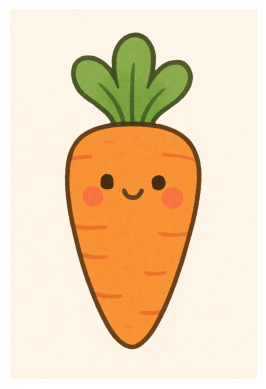

canvas_size: (0.03856117021276595, 0.0895)
 scaled_contours: 1


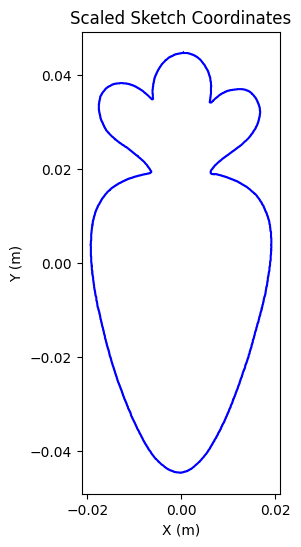

In [15]:
# 사용 예시:
image_path = './image/cute_carrot.png'  # 스케치 이미지 경로 (ex: PNG 파일)
img = mpimg.imread(image_path)
scale=0.5

# 이미지 표시
plt.imshow(img)
plt.axis('off')
plt.show()

scaled_contours, canvas_size = get_scaled_sketch_coordinates(image_path, canvas_width*scale, canvas_height*scale)
print(f"canvas_size: {canvas_size}\n scaled_contours: {len(scaled_contours)}")

converted_contours = [cnt.reshape(-1, 2) for cnt in scaled_contours]
things_to_draw=[]
for cnt in converted_contours:
    cnt[:,0]=cnt[:,0]-np.array([canvas_size[0]/2])
    cnt[:,1]=(cnt[:,1]-np.array([canvas_size[1]/2]))*(-1)# image coordinate(*-1)
    z=np.full((cnt.shape[0],1),appropriate_z_offset)
    result=np.concatenate((cnt,z),axis=1)
    things_to_draw.append(result)

# visualization
plt.figure(figsize=(6, 6))
for cnt in things_to_draw:
    plt.plot(cnt[:, 0], cnt[:, 1], 'b-')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Scaled Sketch Coordinates")
plt.show()

In [16]:
trial=True

In [17]:
from scipy.interpolate import interp1d

def interpolate_contour_traj(contour, num_points=50):
    """
    contour: (N, 3) ndarray
    num_points: 보간 후 trajectory 길이
    시간축 기반 보간 (play_motion_with_interpolation 스타일)
    """
    from scipy.interpolate import interp1d
    import numpy as np

    N = contour.shape[0]
    source_dt = 1.0  # 임의의 단위 시간(예: 1초 간격)로 가정
    source_times = np.arange(N) * source_dt

    target_dt = source_times[-1] / (num_points - 1) if num_points > 1 else 0
    target_times = np.arange(num_points) * target_dt

    traj = np.zeros((num_points, 3))
    for i in range(3):
        interp_func = interp1d(source_times, contour[:, i], kind='linear', bounds_error=False,
                               fill_value=(contour[0, i], contour[-1, i]))
        traj[:, i] = interp_func(target_times)
    return traj

def interpolate_lifted_traj(p_start, p_end, z_lift=0.05, num_points=30):
    """
    p_start, p_end: (3,) ndarray
    z_lift: 중간점에서 z축으로 들어올릴 높이
    """
    mid = (p_start + p_end) / 2
    mid[2] += z_lift
    # 3점(시작-중간-끝)을 선형 보간
    key_points = np.stack([p_start, mid, p_end])
    t = np.linspace(0, 1, 3)
    t_new = np.linspace(0, 1, num_points)
    traj = np.zeros((num_points, 3))
    for i in range(3):
        f = interp1d(t, key_points[:, i], kind='linear')
        traj[:, i] = f(t_new)
    return traj

In [20]:
if trial:
    openmanipulator_path = "../../asset/openmanipulator_x/scene_drawing.xml"
    env=MuJoCoParserClass(name='OpenManipulator-X', rel_xml_path=openmanipulator_path,verbose=False)

    joint_names = ["joint1","joint2","joint3","joint4","gripper_crank_joint"]
    q0 = np.array([0,0,0,0,0.2240])
    p0 = env.get_p_body(body_name="end_effector_target")
    R0 = rpy_deg2r([0,0,0])

    env.reset() # reset
    env.forward(q=q0,joint_names=joint_names) # initial position
    end_effector_pos = env.get_p_body("end_effector_target")

    q_ik_init = q0.copy()
    board_id = mujoco.mj_name2id(env.model,mujoco.mjtObj.mjOBJ_GEOM,"obj_board_geom")

    all_qpos = []
    # 1. 첫 contour의 시작점까지 pen-up으로 이동하는 trajectory 추가
    first_cnt_shifted = things_to_draw[0] + p0
    first_start = first_cnt_shifted[0]
    # 현재 위치(q0)에서 pen-up 상태로 first_start 위로 이동
    p_lift_start = first_start.copy()
    p_lift_start[2] += 0.05
    q_lift_start, _, _ = solve_ik(
        env=env,
        joint_names_for_ik=joint_names[0:4],
        body_name_trgt='end_effector_target',
        q_init=q0[:4],
        p_trgt=p_lift_start,
        R_trgt=None,
        max_ik_tick=1000,
        ik_stepsize=1.0,
        ik_eps=1e-5,
        ik_th=np.radians(5.0),
        render=False,
        verbose_warning=False,
        restore_state=False,
    )
    # pen-up trajectory: q0 → q_lift_start
    penup_to_start = np.linspace(q0[:4], q_lift_start, 30)
    all_qpos.append(penup_to_start)
    # first_start 위에서 z축으로 내려오기
    q_first_start, _, _ = solve_ik(
        env=env,
        joint_names_for_ik=joint_names[0:4],
        body_name_trgt='end_effector_target',
        q_init=q_lift_start,
        p_trgt=first_start,
        R_trgt=None,
        max_ik_tick=1000,
        ik_stepsize=1.0,
        ik_eps=1e-5,
        ik_th=np.radians(5.0),
        render=False,
        verbose_warning=False,
        restore_state=False,
    )
    descend_to_start = np.linspace(q_lift_start, q_first_start, 10)
    all_qpos.append(descend_to_start)
    # z축으로 내려온 후 100스텝 대기
    wait_steps = np.tile(q_first_start, (200, 1))
    all_qpos.append(wait_steps)
    q_ik_init = q_first_start.copy()

    # 2. 각 contour별 trajectory 생성 (contour별 원본 point 개수 유지)
    for i, cnt in enumerate(things_to_draw):
        cnt_shifted = cnt + p0  # (N_i, 3)
        qpos_traj = []
        for p_trgt in cnt_shifted:
            qpos, ik_err_stack, ik_info = solve_ik(
                env=env,
                joint_names_for_ik=joint_names[0:4],
                body_name_trgt='end_effector_target',
                q_init=q_ik_init[:4],
                p_trgt=p_trgt,
                R_trgt=None,
                max_ik_tick=1000,
                ik_stepsize=1.0,
                ik_eps=1e-5,
                ik_th=np.radians(5.0),
                render=False,
                verbose_warning=False,
                restore_state=False,
            )
            qpos_traj.append(qpos.copy())
            q_ik_init = qpos.copy()
        qpos_traj = np.array(qpos_traj)  # (N_i, 4)
        # smoothing/interpolation을 contour의 원래 point 개수(N_i)에 맞춰서만 적용
        t = np.linspace(0, 1, qpos_traj.shape[0])
        t_new = t  # 원본 개수 그대로 유지 (필요시 t_new = np.linspace(0, 1, N_i)로 약간만 늘릴 수 있음)
        qpos_traj_interp = np.zeros((len(t_new), qpos_traj.shape[1]))
        for j in range(qpos_traj.shape[1]):
            f = interp1d(t, qpos_traj[:, j], kind='linear')
            qpos_traj_interp[:, j] = f(t_new)
        all_qpos.append(qpos_traj_interp)
        # 다음 contour로 이동할 때 pen-up trajectory (joint space에서 선형 보간)
        if i < len(things_to_draw) - 1:
            q_last = qpos_traj_interp[-1]
            p_last = cnt_shifted[-1]
            p_lift = p_last.copy()
            p_lift[2] += 0.05
            q_lift, _, _ = solve_ik(
                env=env,
                joint_names_for_ik=joint_names[0:4],
                body_name_trgt='end_effector_target',
                q_init=q_last,
                p_trgt=p_lift,
                R_trgt=None,
                max_ik_tick=1000,
                ik_stepsize=1.0,
                ik_eps=1e-5,
                ik_th=np.radians(5.0),
                render=False,
                verbose_warning=False,
                restore_state=False,
            )
            p_next = things_to_draw[i+1][0] + p0
            p_next[2] += 0.05
            q_next, _, _ = solve_ik(
                env=env,
                joint_names_for_ik=joint_names[0:4],
                body_name_trgt='end_effector_target',
                q_init=q_lift,
                p_trgt=p_next,
                R_trgt=None,
                max_ik_tick=1000,
                ik_stepsize=1.0,
                ik_eps=1e-5,
                ik_th=np.radians(5.0),
                render=False,
                verbose_warning=False,
                restore_state=False,
            )
            penup_traj = np.linspace(q_lift, q_next, 30)
            all_qpos.append(penup_traj)
    # 마지막 위치에서 home으로 복귀 trajectory(optional)
    home_traj = np.linspace(all_qpos[-1][-1], q0[0:4], 30)
    all_qpos.append(home_traj)

    qpos_to_draw = np.vstack(all_qpos)
    print(f"qpos_to_draw: {np.shape(qpos_to_draw)}")

qpos_to_draw: (3561, 4)


In [21]:
# texture options
texture_scale = 3000
texture_width, texture_height = int(canvas_width*texture_scale), int(canvas_height*texture_scale)
print(f"texture width: {texture_width}, height: {texture_height}")
background_color = (255, 255, 255)

img = Image.new('RGB', (texture_width, texture_height), color=background_color)
draw = ImageDraw.Draw(img)

img.save('../../asset/openmanipulator_x/assets/drawing_board_template.png')

texture width: 375, height: 537


In [22]:
def update_texture(env,img_array,texid,expected_len, tex_adr):

    # image array → flat RGB byte array (bottom-up)
    flat = np.flipud(img_array).astype(np.uint8).flatten()

    # update texture data
    env.model.tex_data[tex_adr : tex_adr + expected_len] = flat
    mujoco.mjr_uploadTexture(env.model, env.viewer.ctx, texid)

def world_to_texture(x, y,
                     canvas_x=0.3, canvas_y=0.0,
                     canvas_width=canvas_width, canvas_height=canvas_height,
                     tex_width=texture_width, tex_height=texture_height):
    """
    Global world (x, y) → texture image (u, v) index
    Corrected for y-axis inversion between world and image space.
    """
    # 기준점
    min_x = canvas_x - canvas_width / 2
    min_y = canvas_y - canvas_height / 2

    # 비율계산 (0 ~ 1)
    rel_x = (x - min_x) / canvas_width
    rel_y = (y - min_y) / canvas_height

    # 이미지 좌표계는 y 증가가 아래쪽이므로 반전 필요
    u = int(rel_x * tex_width)
    # u = int((1 - rel_x) * tex_width)  # 좌우 반전
    v = int((1 - rel_y) * tex_height)

    return u, v


def safe_draw(img_array, x, y, board_x, board_y,tex_width, tex_height, color=(255,0,0)):
    u, v = world_to_texture(x, y, board_x, board_y,tex_width=tex_width, tex_height=tex_height)
    if 0 <= u < tex_width and 0 <= v < tex_height:
        img_array[v, u,:] = color
    return img_array

Scan - baurdates: [1000000], id_range: range(0, 254)
[INFO] Scanning baudrate 1000000...
  - Found ID 11 (proto 2.0, model 1020)
  - Found ID 12 (proto 2.0, model 1020)
  - Found ID 13 (proto 2.0, model 1020)
  - Found ID 14 (proto 2.0, model 1020)
  - Found ID 15 (proto 2.0, model 1020)

[SUMMARY]
  Baud 1000000: [(11, 2.0, 1020), (12, 2.0, 1020), (13, 2.0, 1020), (14, 2.0, 1020), (15, 2.0, 1020)]
motor id list @ 1000000: [11, 12, 13, 14, 15]
Transitioning from current pose to zero pose over 2.0 seconds...
Current poses: ['0.001', '0.001', '0.001', '0.001', '0.226']
Control Hz: 50.0, Steps: 100, dt: 0.020s
Transition to zero pose completed!
drawing texture texid: 2, tex_wd: 375 x 537
window renderer: Apple M3
window vendor: Apple
idx: 0/3561
qpos_to_go: [0.    0.    0.    0.    0.224]
current_qpos: [0.002767177693184351, 0.002767177693184351, 0.002767177693184351, 0.002767177693184351, -0.000767177693184351]
qpos_to_go: [0.    0.    0.    0.    0.224]
idx: 1/3561
qpos_to_go: [ 0.00530

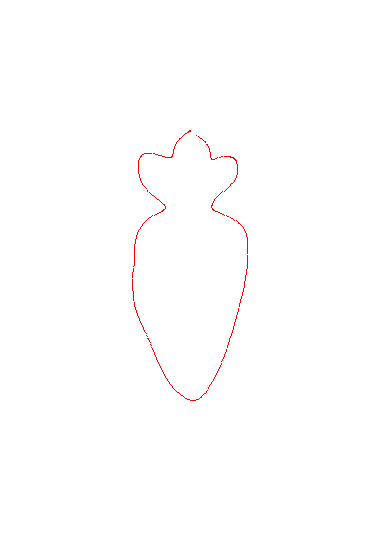

In [23]:
openmanipulator_path = "../../asset/openmanipulator_x/scene_drawing.xml"
env=MuJoCoParserClass(name='OpenManipulator-X', rel_xml_path=openmanipulator_path,verbose=False)
if REAL_ROBOT:
    controller = RobotLauncher(name="omx")
    controller.set_specific_pid(pid=[(25,0,200)],id_list=[15])
    controller.smooth_transition_to_zero(joint_names=["joint1","joint2","joint3","joint4"],duration=2.0)
texid = None
for i in range(env.model.ntex):
    name = mujoco.mj_id2name(env.model, mujoco.mjtObj.mjOBJ_TEXTURE, i)
    if name=="drawing_tex":
        texid=i
        tex_width = env.model.tex_width[i]
        tex_height = env.model.tex_height[i]
        tex_channel = env.model.tex_nchannel[i]
        tex_adr = env.model.tex_adr[i]
        img_array = np.ones((tex_width, tex_height, 3), dtype=np.uint8) * 255  # 하얀 배경

        # sanity check
        expected_len = tex_width * tex_height * tex_channel
        assert env.model.tex_data.shape[0] >= tex_adr + expected_len

        print(f"drawing texture texid: {texid}, tex_wd: {tex_width} x {tex_height}")
        break

idx=0

env.init_viewer(
    title       = 'Drawing',
    transparent = False,
    azimuth     = 120,
    distance    = 0.4,
    elevation   = -42.4,
    lookat      = (0.3,0.0,0.005),
    use_rgb_overlay = True,
    loc_rgb_overlay = 'bottom right'
)
print(f"window renderer: {glGetString(GL_RENDERER).decode()}\nwindow vendor: {glGetString(GL_VENDOR).decode()}")
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
board_pos = env.data.xpos[mujoco.mj_name2id(env.model, mujoco.mjtObj.mjOBJ_BODY,"obj_board")]
while env.is_viewer_alive():
    print(f"idx: {idx}/{len(qpos_to_draw)}")
    if idx >= len(qpos_to_draw):
        qpos = qpos_to_draw[-1]  # 마지막 위치로 유지
    else:
        qpos = qpos_to_draw[idx]
    # update real robot
    if REAL_ROBOT:
        # current_pos = controller.get_current_pose(joint_names=joint_names)
        
        # print(f"ranges: {ranges}\ncurrent qpos: {controller.dxl_present_position}")
        qpos_to_go = np.append(qpos[0:4], q0[-1])
        print(f"qpos_to_go: {qpos_to_go}")
        
        
        controller.run(joint_names=joint_names,qpos=qpos_to_go,)
    
    # update simulation
    if REAL_ROBOT:
        current_qpos = controller.get_current_pose(joint_names=joint_names)
        current_qpos[0:4] += np.array([0.002]) # sim2real gap
        print(f"current_qpos: {current_qpos}\nqpos_to_go: {qpos_to_go}")
        env.step(
            ctrl = current_qpos,
            joint_names = joint_names,
            nstep = 5,
        )
    else:
        if idx>=len(qpos_to_draw):
            print(f"qpos: {qpos}")
        env.step(
            ctrl=np.append(qpos[0:4], q0[-1]),
            joint_names=joint_names,
            nstep=2,
        )
    
    if env.loop_every(tick_every=5):
        img_array = np.flipud(
            env.model.tex_data[tex_adr : tex_adr + expected_len].reshape((tex_height, tex_width, tex_channel))
                )
        
        end_effector_pos = env.data.xpos[
            mujoco.mj_name2id(env.model, mujoco.mjtObj.mjOBJ_BODY, "end_effector_target")
                ]

        d1 = mujoco.mj_rayMesh(
            env.model, env.data,board_id, end_effector_pos, np.array([0, 0, 1])
                ) 
        d2 = mujoco.mj_rayMesh(
            env.model, env.data,board_id, end_effector_pos, np.array([0, 0, -1])
                ) 
        print(f"d1: {d1}, d2: {d2}")
        if REAL_ROBOT:
            d = 0.002+sim2real_gap
        else:
            d=0.002
        if -1 < d1 < d or -1 < d2 < d:
            x,y,_ = end_effector_pos
            img_array = safe_draw(img_array,x,y,board_pos[0],board_pos[1],tex_width,tex_height)
            env.viewer.add_rgb_overlay(rgb_img_raw=img_array, fix_ratio=True)
            update_texture(env,img_array, texid, expected_len, tex_adr)
    if env.loop_every(tick_every=5):#tick_every=1 ~ real time

        env.plot_time()
        env.render()
    idx += 1

img_array = np.flipud(env.model.tex_data[tex_adr : tex_adr + expected_len].reshape((tex_height, tex_width, tex_channel)))
img = Image.fromarray(img_array)
display(img)
timestamp = datetime.datetime.now().strftime("%y_%m_%d_%H_%M_%S")
filename = './result/'+timestamp+'.png'
img.save(filename)
# Close
env.close_viewer()

In [24]:
if REAL_ROBOT:
    input("Press Enter to close the controller...")
    controller.smooth_transition_to_zero(joint_names=joint_names)
    controller.off(off_torque=False)
print ("Done.")

Done.


# Saving Data

In [ ]:
openmanipulator_path = "../../asset/openmanipulator_x/scene_drawing.xml"
env=MuJoCoParserClass(name='OpenManipulator-X', rel_xml_path=openmanipulator_path,verbose=False)

idx=0

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
board_pos = env.data.xpos[mujoco.mj_name2id(env.model, mujoco.mjtObj.mjOBJ_BODY,"obj_board")]
recorded_qpos = np.zeros((len(qpos_to_draw), len(joint_names)))
timestep = np.zeros((len(qpos_to_draw), 1)) # for recording time
# while env.is_viewer_alive():
while idx<len(qpos_to_draw):
    a=time.time()
    print(f"idx: {idx}/{len(qpos_to_draw)}")
    if idx >= len(qpos_to_draw):
        qpos = qpos_to_draw[-1]  # 마지막 위치로 유지
    else:
        qpos = qpos_to_draw[idx]

    env.step(
        ctrl=np.append(qpos[0:4], q0[-1]),
        joint_names=joint_names,
        nstep=5,
    )
    recorded_qpos[idx,:] = np.append(qpos[0:4], q0[-1])
    timestep[idx] = env.get_sim_time()

    idx += 1
    env.sync_sim_wall_time()
    b=time.time()
    print(f"tick time: {b-a:.3f} sec")

np.savez(
    './result/timestep_and_qpos.npz',
    timestep=timestep,
    qpos=recorded_qpos,
)

idx: 0/3561
tick time: 0.011 sec
idx: 1/3561
tick time: 0.010 sec
idx: 2/3561
tick time: 0.010 sec
idx: 3/3561
tick time: 0.010 sec
idx: 4/3561
tick time: 0.010 sec
idx: 5/3561
tick time: 0.010 sec
idx: 6/3561
tick time: 0.010 sec
idx: 7/3561
tick time: 0.010 sec
idx: 8/3561
tick time: 0.010 sec
idx: 9/3561
tick time: 0.010 sec
idx: 10/3561
tick time: 0.010 sec
idx: 11/3561
tick time: 0.009 sec
idx: 12/3561
tick time: 0.011 sec
idx: 13/3561
tick time: 0.010 sec
idx: 14/3561
tick time: 0.010 sec
idx: 15/3561
tick time: 0.010 sec
idx: 16/3561
tick time: 0.010 sec
idx: 17/3561
tick time: 0.010 sec
idx: 18/3561
tick time: 0.010 sec
idx: 19/3561
tick time: 0.010 sec
idx: 20/3561
tick time: 0.010 sec
idx: 21/3561
tick time: 0.010 sec
idx: 22/3561
tick time: 0.010 sec
idx: 23/3561
tick time: 0.010 sec
idx: 24/3561
tick time: 0.009 sec
idx: 25/3561
tick time: 0.011 sec
idx: 26/3561
tick time: 0.010 sec
idx: 27/3561
tick time: 0.010 sec
idx: 28/3561
tick time: 0.009 sec
idx: 29/3561
tick time: 